In [1]:
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def extract_clean_spectrum(path, namefile):
    """
    Extrae y limpia el espectro de un archivo FITS o ASCII manteniendo las unidades originales.
    
    Arguments:
    path (str): Ruta al directorio que contiene el archivo.
    namefile (str): Nombre del archivo FITS o ASCII.
    
    Returns:
    tuple: Tupla con longitudes de onda limpias y datos de flux originales.
    """
    if namefile.endswith(".fits"):
        with fits.open(os.path.join(path, namefile)) as hdul:
            flux = hdul[1].data  # Unidades originales
            nx, wav0, i0, dwav = [hdul[1].header[k] for k in ("NAXIS1", "CRVAL1", "CRPIX1", "CD1_1")]
            wavelengths = wav0 + (np.arange(nx) - (i0 - 1)) * dwav
    else:
        # Cargar datos desde archivo ASCII con formato específico
        try:
            # Leer el archivo ASCII, saltando las dos primeras líneas de encabezado
            data = ascii.read(os.path.join(path, namefile), 
                             format='basic', 
                             delimiter=' ', 
                             data_start=2,  # Saltar las primeras 2 líneas
                             names=['wavelength', 'flux'])  # Nombres personalizados para las columnas
            
            # Extraer longitudes de onda en nanómetros y flux
            wavelengths = data['wavelength'].data
            flux = data['flux'].data
                
        except Exception as e:
            print(f"Error al leer el archivo ASCII: {e}")
            return None, None
    
    # Definir el rango a eliminar (sin corrección de redshift) - ahora en nm
    remove_range = (wavelengths >= 612) & (wavelengths <= 638)
    
    # Aplicar filtro estableciendo los valores de flux como NaN en el rango eliminado
    clean_flux = np.where(remove_range, np.nan, flux)

    # Manejar valores negativos de flux estableciéndolos como NaN
    clean_flux = np.where(clean_flux < 0, np.nan, clean_flux)

    # Ajustar el continuo usando un filtro mediano
    kernel_size = min(101, len(clean_flux) - 1) if len(clean_flux) > 1 else 1
    if kernel_size % 2 == 0:  # Asegurar que kernel_size sea impar
        kernel_size -= 1
    
    continuum_fit = medfilt(clean_flux, kernel_size=kernel_size)
    
    # Establecer un umbral por debajo del ajuste del continuo
    threshold = continuum_fit - 0.25 * continuum_fit
    
    # Eliminar valores de flux significativamente por debajo del continuo
    clean_flux = np.where(clean_flux < threshold, np.nan, clean_flux)
    
    # Interpolar para llenar los valores NaN
    valid = ~np.isnan(clean_flux) & ~remove_range
    if np.sum(valid) > 1:  # Asegurarse de que hay suficientes puntos para interpolar
        interpolator = interp1d(wavelengths[valid], clean_flux[valid], 
                               kind='linear', bounds_error=False, fill_value="extrapolate")
        filled_flux = interpolator(wavelengths)
    else:
        filled_flux = clean_flux.copy()
    
    # Reaplicar la máscara remove_range para mantenerla en blanco
    filled_flux[remove_range] = np.nan
    
    # En su lugar, mantener todo el rango espectral
    clean_wavelengths = wavelengths
    
    return clean_wavelengths, filled_flux

In [3]:
def save_spectrum_ascii(wavelengths, flux, filename, header_info=None):
    """
    Guarda el espectro en formato ASCII estándar con encabezado informativo.
    
    Arguments:
    wavelengths (array): Array de longitudes de onda (en nm).
    flux (array): Array de valores de flux.
    filename (str): Nombre del archivo de salida.
    header_info (dict): Diccionario con información adicional para el encabezado (opcional).
    """
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    with open(filename, 'w') as f:
        # Escribir encabezado informativo
        f.write("# Cleaned spectrum data (original units)\n")
        f.write("# Format: Wavelength(nm) Flux(Wm^-2nm^-1)\n")
        f.write("# Created with Python spectrum processing script\n")
        
        # Agregar información adicional si se proporciona
        if header_info:
            for key, value in header_info.items():
                f.write(f"# {key}: {value}\n")
        
        f.write("# \n")
        f.write("# Wavelength    Flux\n")
        f.write("# ---------    ----\n")
        
        # Escribir los datos
        for w, fl in zip(wavelengths, flux):
            f.write(f"{w:.4f}    {fl:.6e}\n")


In [4]:
def plot_clean_spectrum(wavelengths, flux, object_name=None, save_path=None):
    """
    Genera un gráfico del espectro limpio para verificación visual.
    
    Arguments:
    wavelengths (array): Array de longitudes de onda (en nm).
    flux (array): Array de valores de flux.
    object_name (str): Nombre del objeto para el título (opcional).
    save_path (str): Ruta para guardar el gráfico (opcional).
    """
    plt.figure(figsize=(12, 6))
    
    # Crear el gráfico
    plt.plot(wavelengths, flux, 'b-', linewidth=0.8)
    plt.xlabel('Wavelength (nm)', fontsize=14)
    plt.ylabel('Flux (Wm^-2nm^-1)', fontsize=14)
    
    # Añadir título si se proporciona el nombre del objeto
    if object_name:
        plt.title(f'Cleaned Spectrum: {object_name}', fontsize=16)
    else:
        plt.title('Cleaned Spectrum', fontsize=16)
    
    # Añadir grid para mejor visualización
    plt.grid(True, alpha=0.3)
    
    # Ajustar los límites para enfocar en la región de interés
    #plt.xlim(wavelengths[0], wavelengths[-1])
    
    # Ajustar el límite y para excluir outliers extremos
    y_min = np.nanpercentile(flux, 5)
    y_max = np.nanpercentile(flux, 95)
    #plt.ylim(y_min, y_max * 1.05)
    
    # Formatear los ejes
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Guardar el gráfico si se especifica una ruta
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Gráfico guardado en: {save_path}")
    
    plt.show()

In [5]:
# Configuración
path = "../spectra_luis/"
namefile = "n02n27_1D_aberturaOIII_test.fits"

In [6]:
# Extraer el espectro limpio (sin corrección de redshift, unidades originales)
wavelengths, flux = extract_clean_spectrum(path, namefile)

# Guardar el espectro limpio en formato ASCII
header_info = {
    "Object": "DR4_3_SPLUS-n02n27_0037849",
    "Processing_date": "2025-08-12",
    "Original_file": namefile,
    "Note": "Original units",
    "Wavelength_units": "nm"
}

save_spectrum_ascii(wavelengths, flux, "../Cleaned-spectra/n02n27_1D_aberturaOIII_test_cleaned.txt", header_info)

print("Espectro limpio guardado exitosamente en '../Cleaned-spectra/n02n27_1D_aberturaOIII_test_cleaned.txt'")
print(f"Longitud del espectro: {len(wavelengths)} puntos")
print(f"Rango de longitudes de onda: {wavelengths[0]:.2f} - {wavelengths[-1]:.2f} nm")

Espectro limpio guardado exitosamente en '../Cleaned-spectra/n02n27_1D_aberturaOIII_test_cleaned.txt'
Longitud del espectro: 6455 puntos
Rango de longitudes de onda: 423.27 - 749.02 nm


Gráfico guardado en: ../Cleaned-spectra/n02n27_1D_aberturaOIII_test_cleaned.png


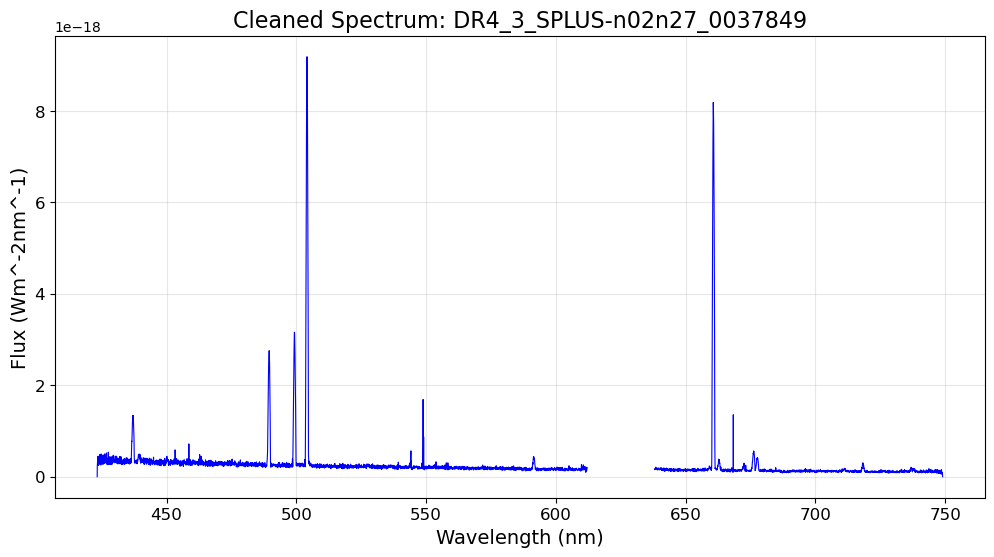

In [7]:
# Generar y mostrar gráfico de verificación
plot_clean_spectrum(wavelengths, flux, 
                   object_name="DR4_3_SPLUS-n02n27_0037849",
                   save_path="../Cleaned-spectra/n02n27_1D_aberturaOIII_test_cleaned.png")

# Creating the final spectra

In [8]:
# Configuración
path1 = "../Spectra_txt/"
namefile1 = "n13s01_new_apOIII.txt"

In [9]:
# Extraer el espectro limpio (sin corrección de redshift, unidades originales)
wavelengths1, flux1 = extract_clean_spectrum(path1, namefile1)

# Guardar el espectro limpio en formato ASCII
header_info1 = {
    "Object": "DR4_3_SPLUS-n13s01_0024584",
    "Processing_date": "2025-08-12",
    "Original_file": namefile1,
    "Note": "Original units",
    "Wavelength_units": "nm"
}

save_spectrum_ascii(wavelengths1, flux1, "../Cleaned-spectra/n13s01_new_apOIII_cleaned.txt", header_info1)

print("Espectro limpio guardado exitosamente en '../Cleaned-spectra/n13s01_new_apOIII_cleaned.txt'")
print(f"Longitud del espectro: {len(wavelengths1)} puntos")
print(f"Rango de longitudes de onda: {wavelengths1[0]:.2f} - {wavelengths1[-1]:.2f} nm")

Espectro limpio guardado exitosamente en '../Cleaned-spectra/n13s01_new_apOIII_cleaned.txt'
Longitud del espectro: 6458 puntos
Rango de longitudes de onda: 423.37 - 749.06 nm


Gráfico guardado en: ../Cleaned-spectra/n13s01_new_apOIII_cleaned.png


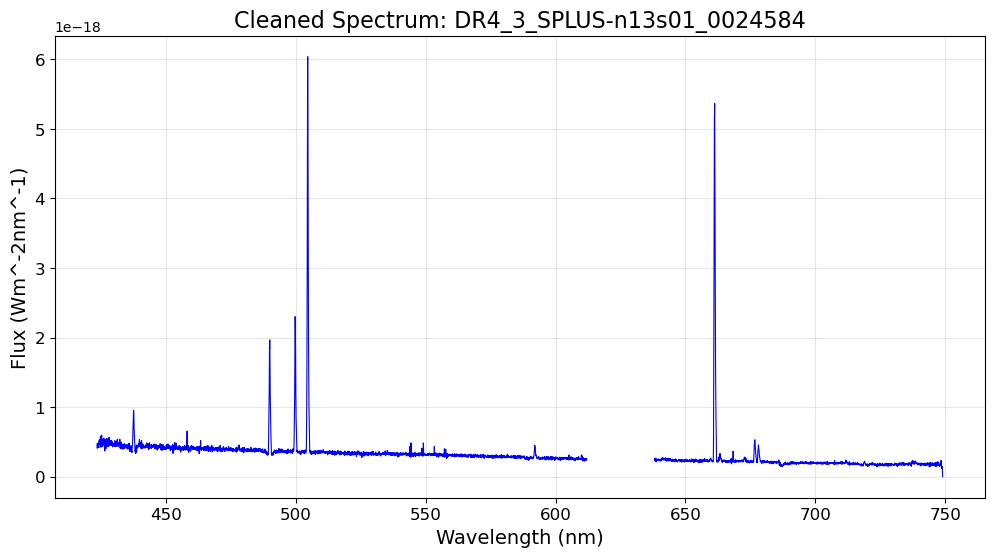

In [10]:
# Generar y mostrar gráfico de verificación
plot_clean_spectrum(wavelengths1, flux1, 
                   object_name="DR4_3_SPLUS-n13s01_0024584",
                   save_path="../Cleaned-spectra/n13s01_new_apOIII_cleaned.png")

# Spectra 3

In [11]:
# Configuración
path2 = "../Spectra_txt/"
namefile2 = "s27s07_new_apOIII.txt"

# Extraer el espectro limpio (sin corrección de redshift, unidades originales)
wavelengths2, flux2 = extract_clean_spectrum(path2, namefile2)

# Guardar el espectro limpio en formato ASCII
header_info2 = {
    "Object": "DR4_3_SPLUS-s27s07_0011404",
    "Processing_date": "2025-08-12",
    "Original_file": namefile2,
    "Note": "Original units",
    "Wavelength_units": "nm"
}

save_spectrum_ascii(wavelengths2, flux2, "../Cleaned-spectra/s27s07_new_apOIII_cleaned.txt", header_info2)

print("Espectro limpio guardado exitosamente en '../Cleaned-spectra/s27s07_new_apOIII_cleaned.txt'")
print(f"Longitud del espectro: {len(wavelengths2)} puntos")
print(f"Rango de longitudes de onda: {wavelengths2[0]:.2f} - {wavelengths2[-1]:.2f} nm")

Espectro limpio guardado exitosamente en '../Cleaned-spectra/s27s07_new_apOIII_cleaned.txt'
Longitud del espectro: 3225 puntos
Rango de longitudes de onda: 423.44 - 748.89 nm


Gráfico guardado en: ../Cleaned-spectra/s27s07_new_apOIII_cleaned.png


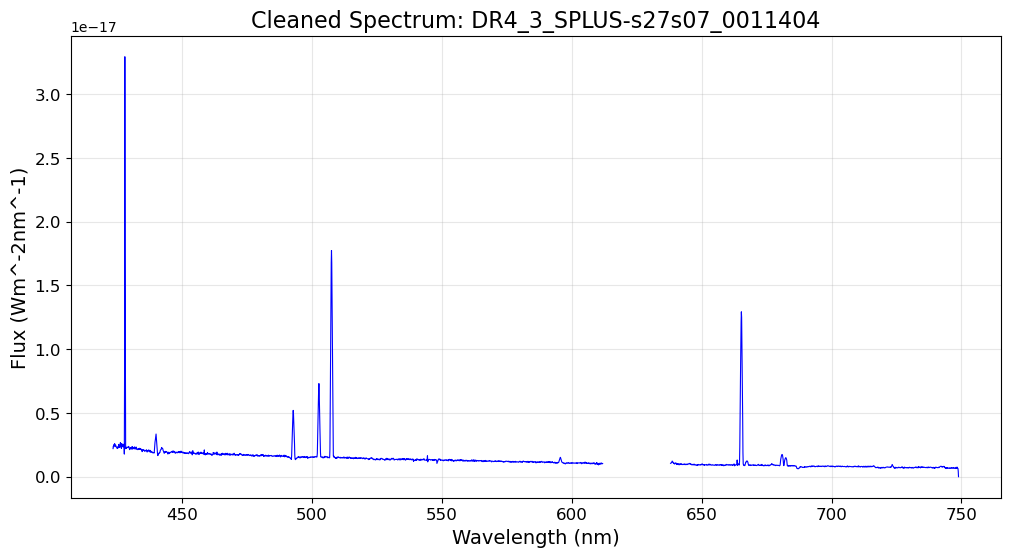

In [12]:
# Generar y mostrar gráfico de verificación
plot_clean_spectrum(wavelengths2, flux2, 
                   object_name="DR4_3_SPLUS-s27s07_0011404",
                   save_path="../Cleaned-spectra/s27s07_new_apOIII_cleaned.png")

# Spectra 4

In [13]:
namefile3 = "n14s01_1D_aberturaOIII.fits"

# Extraer el espectro limpio (sin corrección de redshift, unidades originales)
wavelengths3, flux3 = extract_clean_spectrum(path, namefile3)

# Guardar el espectro limpio en formato ASCII
header_info3 = {
    "Object": "DR4_3_SPLUS-n14s01_0028263",
    "Processing_date": "2025-08-12",
    "Original_file": namefile3,
    "Note": "Original units",
    "Wavelength_units": "nm"
}

save_spectrum_ascii(wavelengths3, flux3, "../Cleaned-spectra/n14s01_1D_aberturaOIII_cleaned.txt", header_info3)

print("Espectro limpio guardado exitosamente en '../Cleaned-spectra/n14s01_1D_aberturaOIII_cleaned.txt'")
print(f"Longitud del espectro: {len(wavelengths3)} puntos")
print(f"Rango de longitudes de onda: {wavelengths3[0]:.2f} - {wavelengths3[-1]:.2f} nm")

Espectro limpio guardado exitosamente en '../Cleaned-spectra/n14s01_1D_aberturaOIII_cleaned.txt'
Longitud del espectro: 6459 puntos
Rango de longitudes de onda: 423.31 - 748.98 nm


Gráfico guardado en: ../Cleaned-spectra/n14s01_1D_aberturaOIII_cleaned.png


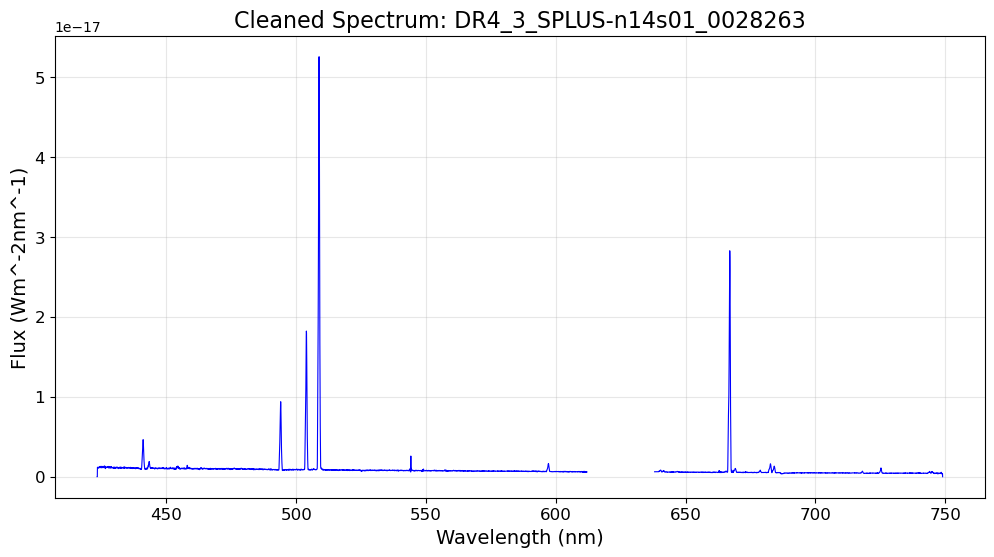

In [14]:
# Generar y mostrar gráfico de verificación
plot_clean_spectrum(wavelengths3, flux3, 
                   object_name="DR4_3_SPLUS-n14s01_0028263",
                   save_path="../Cleaned-spectra/n14s01_1D_aberturaOIII_cleaned.png")